In [1]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## 1. Visualize

In [ ]:
data = scipy.io.loadmat('/Users/poseidon/Documents/NSSP/project_2_nssp/data/S1_A1_E1.mat')

glove_data = data['glove']
selected_joints = [2, 5, 7, 10, 13]  # Joints 3, 6, 8, 11, 14
joint_angles = glove_data[:, selected_joints]

In [3]:
repetition_data = data['rerepetition'].flatten()
print(repetition_data)

[0 0 0 ... 0 0 0]


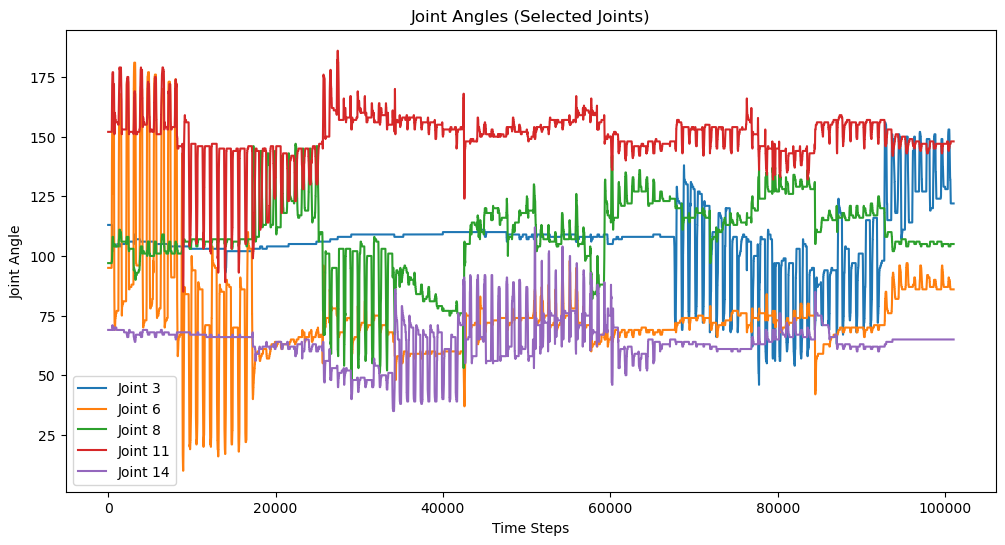

In [4]:
plt.figure(figsize=(12, 6))
for i, joint in enumerate(selected_joints, start=1):
    plt.plot(joint_angles[:, i - 1], label=f'Joint {joint + 1}')
plt.title("Joint Angles (Selected Joints)")
plt.xlabel("Time Steps")
plt.ylabel("Joint Angle")
plt.legend()
plt.show()

In [ ]:

# Normalize 
scaler = MinMaxScaler()
normalized_joint_angles = scaler.fit_transform(joint_angles)

# Split data based on repetitions
# Training: repetitions 1-4 and 7-10
train_indices = np.where((repetition_data >= 1) & (repetition_data <= 4) | (repetition_data >= 7) & (repetition_data <= 10))[0]
# Testing: repetitions 5-6
test_indices = np.where((repetition_data >= 5) & (repetition_data <= 6))[0]

# Extract training and testing sets
train_data = normalized_joint_angles[train_indices]
test_data = normalized_joint_angles[test_indices]

# validation sets
val_size = 0.2  # 20% of the training data for validation
val_end = int(val_size * train_data.shape[0])

train_set = train_data[:-val_end]
val_set = train_data[-val_end:]


print(f"Training data size: {train_set.shape}")
print(f"Validation data size: {val_set.shape}")
print(f"Test data size: {test_data.shape}")

Training data size: (23939, 5)
Validation data size: (5984, 5)
Test data size: (7777, 5)


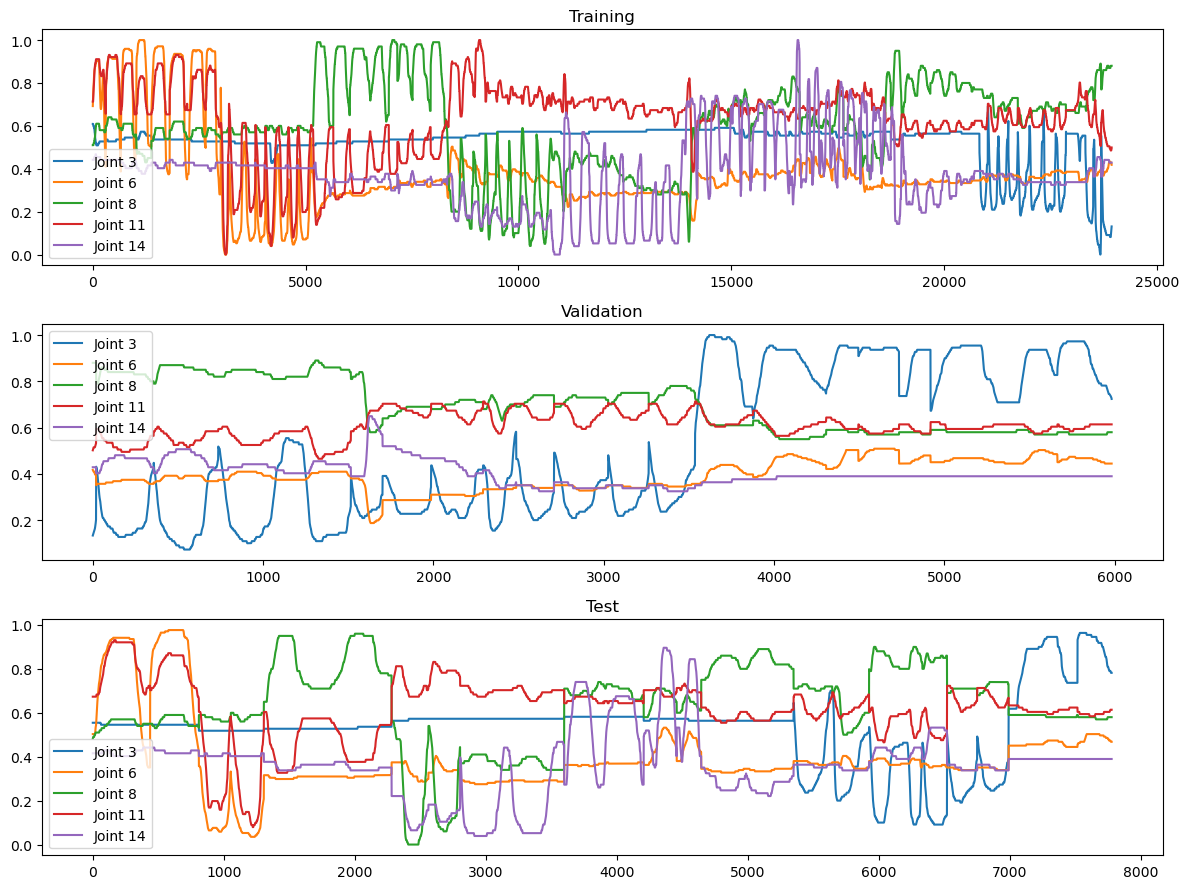

In [18]:
plt.figure(figsize=(12, 9))

# Train 
plt.subplot(3, 1, 1)
for i in range(train_set.shape[1]):
    plt.plot(train_set[:, i], label=f'Joint {selected_joints[i] + 1}')
plt.title("Training")
plt.legend()

# Validation 
plt.subplot(3, 1, 2)
for i in range(val_set.shape[1]):
    plt.plot(val_set[:, i], label=f'Joint {selected_joints[i] + 1}')
plt.title("Validation")
plt.legend()

# Test 
plt.subplot(3, 1, 3)
for i in range(test_data.shape[1]):
    plt.plot(test_data[:, i], label=f'Joint {selected_joints[i] + 1}')
plt.title("Test")
plt.legend()

plt.tight_layout()
plt.show()

A ENLEVER

- plots between 0 and 1 : good normalization 
- Low values (near 0): Represent the joint being in an extended position.
- High values (near 1): Represent the joint being in a flexed  osition.

# 2.Sliding windows

In [7]:
def sliding_window(data, window_width, step):
    """
    Perform sliding window segmentation on the input data.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - window_width: number of time steps in each window
    - step: step size for the sliding window

    Returns:
    - segmented_data: numpy array of shape (n_windows, window_width, n_features)
    """
    n_samples, n_features = data.shape
    segmented_data = []

    for start in range(0, n_samples - window_width + 1, step):
        end = start + window_width
        segmented_data.append(data[start:end])

    return np.array(segmented_data)


window_width = 50  
step = 10          


train_windows = sliding_window(train_set, window_width, step)
val_windows = sliding_window(val_set, window_width, step)
test_windows = sliding_window(test_data, window_width, step)


print(f"Training windows shape: {train_windows.shape}")
print(f"Validation windows shape: {val_windows.shape}")
print(f"Test windows shape: {test_windows.shape}")


Training windows shape: (2389, 50, 5)
Validation windows shape: (594, 50, 5)
Test windows shape: (773, 50, 5)


A JUSTIFER LE WW and SS !!!!

# 3.Extract set features

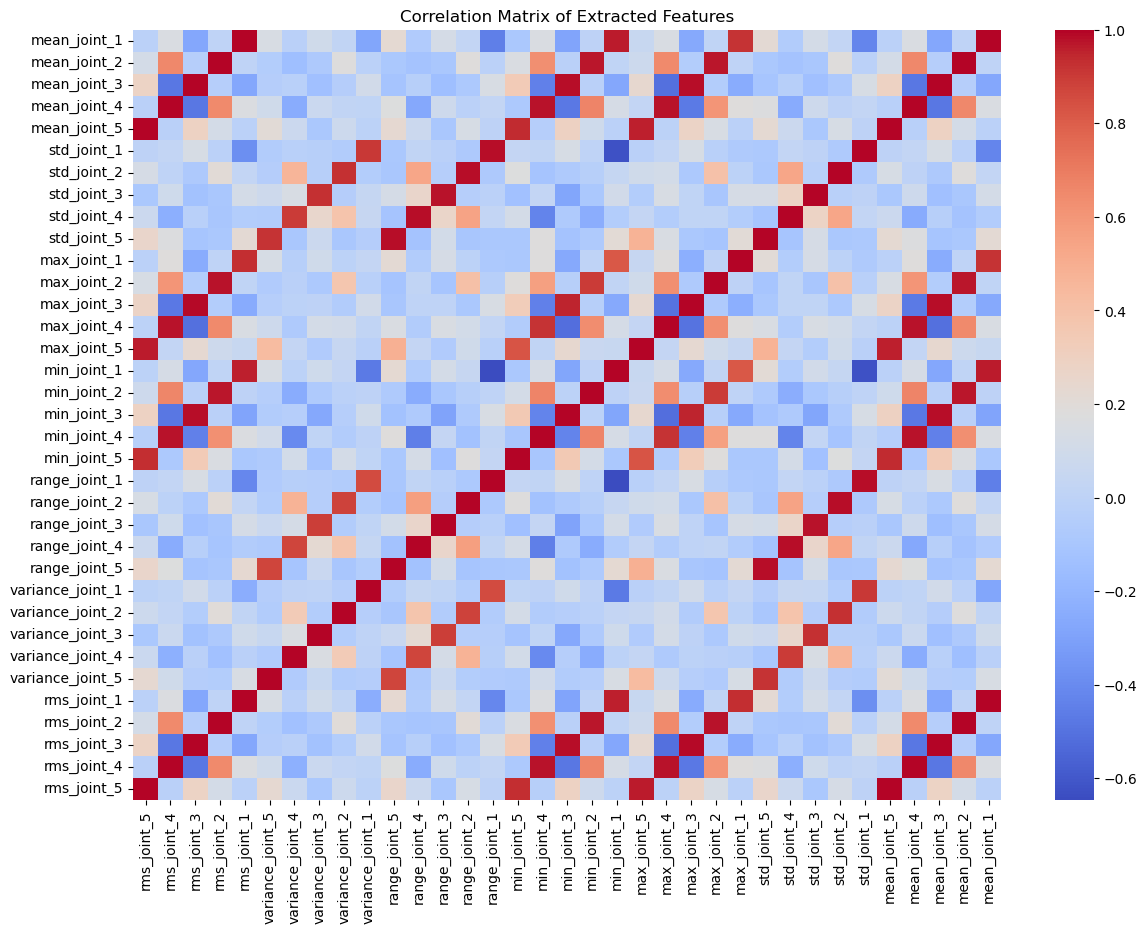

In [10]:
def extract_features(data_windows):
    """
    Extract statistical and signal-processing features from sliding window data.

    Parameters:
    - data_windows: numpy array of shape (n_windows, window_width, n_features)

    Returns:
    - features: numpy array of extracted features (n_windows, n_features * n_extracted_features)
    """
    features = []
    for window in data_windows:
        # Statistical features
        mean = np.mean(window, axis=0)
        std = np.std(window, axis=0)
        max_val = np.max(window, axis=0)
        min_val = np.min(window, axis=0)
        range_val = max_val - min_val
        variance = np.var(window, axis=0)
        rms = np.sqrt(np.mean(window**2, axis=0))

        window_features = np.hstack([mean, std, max_val, min_val, range_val, variance, rms])
        features.append(window_features)

    return np.array(features)

# Extract features
train_features = extract_features(train_windows)
val_features = extract_features(val_windows)
test_features = extract_features(test_windows)

# Normalize the features
scaler = MinMaxScaler()
train_features_normalized = scaler.fit_transform(train_features)

# Create a DataFrame for the correlation analysis
feature_labels = ['mean', 'std', 'max', 'min', 'range', 'variance', 'rms']
joint_labels = [f'joint_{i+1}' for i in range(train_windows.shape[2])]
columns = [f'{label}_{joint}' for label in feature_labels for joint in joint_labels]

train_features_df = pd.DataFrame(train_features_normalized, columns=columns)


# Correlation matrix
correlation_matrix = train_features_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.gca().invert_xaxis() 

plt.title("Correlation Matrix of Extracted Features")
plt.show()

#### Extracted Features:
We computed the following features from each sliding window:
- **Mean**: Average value of joint angles within the window.
- **Standard Deviation (std)**: Variation in joint angles.
- **Maximum (max)** and **Minimum (min)**: Peak values of joint angles.
- **Range**: Difference between maximum and minimum joint angles.
- **Variance**: Measure of joint angle variability.
- **Root Mean Square (RMS)**: A measure reflecting the magnitude of joint angle movements.

#### Normalization:
We applied Min-Max Scaling to normalize all extracted features into the range `[0, 1]` for better interpretability and to ensure features are on a comparable scale.

#### Correlation Analysis:
- **High Correlation**:
    - Features derived from the same joint (e.g., `mean_joint_1` and `rms_joint_1`) show strong correlations, as they are statistically related.
    - Features like `max`, `min`, and `range` are highly correlated due to their dependency on movement amplitude.
- **Low or No Correlation**:
    - Features across different joints (e.g., `mean_joint_1` vs. `std_joint_2`) generally exhibit lower correlations, indicating relative independence of movements across joints.
- **Feature Redundancy**:
    - Some features, like `variance` and `std`, are nearly identical, indicating potential redundancy that could be addressed during feature selection.

#### Observations:
The correlation matrix reveals strong internal relationships among features derived from the same joint. This insight can guide dimensionality reduction techniques (e.g., PCA) or feature selection to remove redundant information, simplifying the model without sacrificing performance.


# 4.SVM

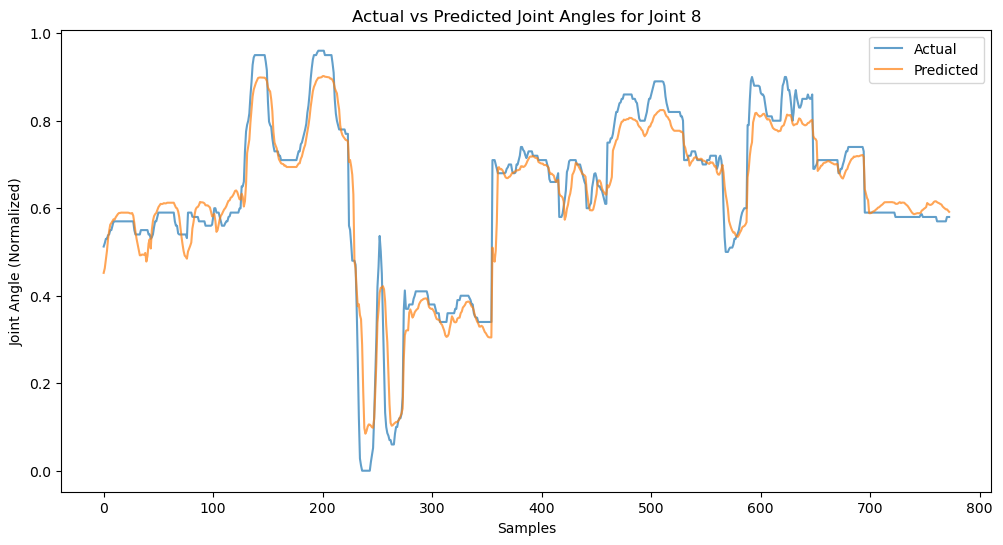

Joint 3: MSE = 0.0103, R² = 0.6433
Joint 6: MSE = 0.0030, R² = 0.9075
Joint 8: MSE = 0.0030, R² = 0.9218
Joint 11: MSE = 0.0029, R² = 0.8680
Joint 14: MSE = 0.0055, R² = 0.7620


In [9]:
# Correct the target variable alignment to match sliding windows
train_targets = train_set[window_width - 1::step] 
val_targets = val_set[window_width - 1::step]
test_targets = test_data[window_width - 1::step]

svr_models = []
test_predictions = []
mse_scores = []
r2_scores = []

# Train SVR models for each joint 
for joint in range(train_targets.shape[1]):
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(train_features_normalized, train_targets[:, joint])
    svr_models.append(svr)

    predictions = svr.predict(scaler.transform(test_features))
    test_predictions.append(predictions)

    mse = mean_squared_error(test_targets[:, joint], predictions)
    r2 = r2_score(test_targets[:, joint], predictions)
    mse_scores.append(mse)
    r2_scores.append(r2)


test_predictions = np.array(test_predictions).T


plt.figure(figsize=(12, 6))
joint_idx = 2  # Index for the joint to visualize [0,4]
plt.plot(test_targets[:, joint_idx], label="Actual", alpha=0.7)
plt.plot(test_predictions[:, joint_idx], label="Predicted", alpha=0.7)
plt.title(f"Actual vs Predicted Joint Angles for Joint {selected_joints[joint_idx] + 1}")
plt.xlabel("Samples")
plt.ylabel("Joint Angle (Normalized)")
plt.legend()
plt.show()

for i, joint in enumerate(selected_joints):
    print(f"Joint {joint + 1}: MSE = {mse_scores[i]:.4f}, R² = {r2_scores[i]:.4f}")

- **Model**: Support Vector Regression (SVR) 
- **Training**: Separate SVR models were trained for each joint to predict joint angles based on extracted features.
- **Evaluation**: Performance was measured using:
  - Mean Squared Error (MSE): Lower values indicate better predictions.
  - R² Score: Measures how well predictions match actual values (closer to 1 indicates better performance).

#### Results:
- **Performance Metrics**:
  - Joint 3: MSE = 0.0103, R² = 0.6433
  - Joint 6: MSE = 0.0030, R² = 0.9075
  - Joint 8: MSE = 0.0030, R² = 0.9218
  - Joint 11: MSE = 0.0029, R² = 0.8680
  - Joint 14: MSE = 0.0055, R² = 0.7620

#### Observations:
**High Accuracy**: Joints 6, 8, and 11 exhibit high R² scores (~0.87-0.92), indicating accurate predictions of joint angles.
**Moderate Performance**: Joint 3 has a lower R² score (~0.64), suggesting the model struggles with this joint, possibly due to more complex movement patterns or noisier data.



# 5.Metrics

   Joint       MSE        R²
0      3  0.010253  0.643306
1      6  0.002991  0.907465
2      8  0.002955  0.921825
3     11  0.002862  0.867999
4     14  0.005523  0.762020


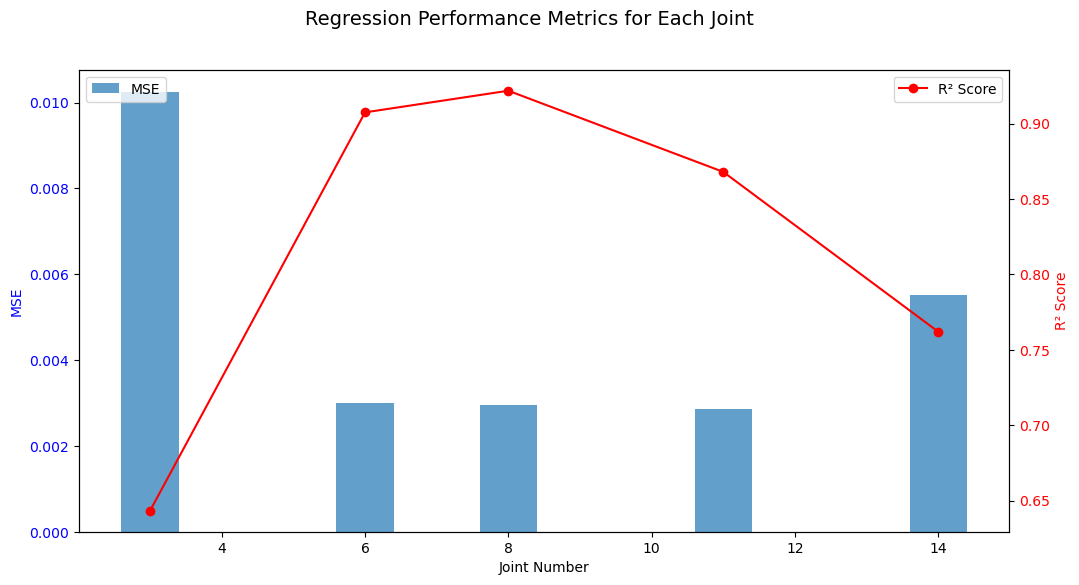

In [ ]:
performance_metrics = []
for i, joint in enumerate(selected_joints):
    performance_metrics.append({
        "Joint": joint + 1,
        "MSE": mse_scores[i],
        "R²": r2_scores[i]
    })

metrics_df = pd.DataFrame(performance_metrics)
print(metrics_df)


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MSE
ax1.bar(metrics_df["Joint"], metrics_df["MSE"], alpha=0.7, label="MSE")
ax1.set_xlabel("Joint Number")
ax1.set_ylabel("MSE", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Plot R² scores (secondary axis)
ax2 = ax1.twinx()
ax2.plot(metrics_df["Joint"], metrics_df["R²"], color="red", marker="o", label="R² Score")
ax2.set_ylabel("R² Score", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.suptitle("Regression Performance Metrics for Each Joint", fontsize=14)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


#### Metrics Used:
1. **Mean Squared Error**:Represents the average squared difference between predicted and actual joint angles. Penalizes larger errors more heavily.
2. **R² Score**: Indicates the proportion of variance in the joint angles explained by the regression model. A value closer to 1 implies better predictive performance.

#### Results:
| Joint | MSE     | R² Score |
|-------|---------|----------|
| 3     | 0.0103  | 0.6433   |
| 6     | 0.0030  | 0.9075   |
| 8     | 0.0030  | 0.9218   |
| 11    | 0.0029  | 0.8680   |
| 14    | 0.0055  | 0.7620   |

#### Observations:
1. **MSE**:
   - Joints 6, 8, and 11 have low MSE values (~0.003), indicating accurate predictions with minimal error.
   - Joint 3 shows the highest MSE (0.0103), suggesting the model struggles more with this joint.
   
2. **R² Score**:
   - Joints 6, 8, and 11 achieve high R² scores (>0.86), reflecting strong predictive capabilities.
   - Joint 3 has a lower R² score (0.64), indicating potential room for improvement.

#### Suitability of Metrics:
- **MSE** is suitable because precise joint angle predictions are critical for robotic hand control, and larger errors must be penalized more heavily.
- **R² Score** is useful for interpreting how well the model captures the variability in joint angles.

#### Conclusion:
- The regression model performs well overall, especially for Joints 6, 8, and 11.
- Improvements can be made for Joint 3, possibly through:
  - Feature engineering or selection.
  - Hyperparameter tuning for SVM.
  - Exploring other regression methods for comparison.


# 6.SVM performance

#### Observations:

Stable Performance:
Joints 6, 8, and 11 show consistent regression performance : High R² scores (>0.86) & low MSE values (~0.003).
This indicates the model predicts these joint angles with high stability and accuracy.

Substantial Differences :
- Joint 3 exhibits lower predictive accuracy: R² score: 0.64 & MSE: 0.0103.
- The performance for Joint 14 is moderate (R²: 0.76, MSE: 0.0055) but better than Joint 3.

#### Possible Explanations for Differences:

**Bio Variability**:
- Joint 3 may correspond to a finger (e.g., thumb) with unique or irregular movement patterns, making it harder to predict.
- Joints 6, 8, and 11 might correspond to fingers with smoother, more uniform movements, resulting in better predictions.

**Data Characteristics**:
- Joint 3's data may have more noise or a wider range of movement compared to other joints.
- The distribution of joint angles for these joints could vary, influencing regression performance.

**Model Limitations**:
- The SVM regressor may struggle with complex, non-linear dependencies present in Joint 3's movement data.
- Joints with more predictable patterns are easier for the SVM to model effectively.



#### Conclusion:
- The regression performance is **not stable** across all finger angles.
- Joints 6, 8, and 11 exhibit strong and consistent performance, while Joint 3 shows noticeable weaknesses.
- Addressing these differences might involve:
  - Exploring alternative regression models
  - Investigating Joint 3's data for noise or outliers.
  - Additional features that capture unique characteristics of Joint 3's movement.
